# covid stuff

----------------------------------------

- **created** by z: `2020-03-30`
- last **updated**: `2020-04-02T11:25:14PDT`

## _preamble_

#### import packages

In [218]:
import pathlib
import requests
import re
import math
import numpy as np
import pandas as pd
from IPython.display import display as disp
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.tools as tls
from plotly.offline import iplot

#### disable request warning

In [109]:
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

#### directories

In [110]:
# cwd = pathlib.Path.cwd()
# cwd
# docs_dir = pathlib.Path("/private/var/mobile/Library/Mobile Documents/iCloud~AsheKube~Carnets/Documents")
# data_dir = docs_dir / "data"

# where data will be saved/loaded
data_dir = pathlib.Path("/Users/zarek/Dropbox/code/github/zcovid/data")
if not data_dir.is_dir():
    data_dir.mkdir()
    print(">>> created dir {}".format(data_dir))

#### URLs

In [111]:
# base URL for data downloads
base_tsdata_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data"

#### regexes

In [112]:
date_re = re.compile(r"\d+/\d+/\d+")

#### time-series keys

In [113]:
# for file names and saving data
tskeys = [
    'confirmed_US',
    'confirmed_global',
    'deaths_US',
    'deaths_global',
    'recovered_global'
]

#### utility functions

In [114]:
# sinum(): format number SI

SINUM_PREFIXES = {
    -6: {'short': "a", 'long': "atto"},
    -5: {'short': "f", 'long': "femto"},
    -4: {'short': "p", 'long': "pico"},
    -3: {'short': "n", 'long': "nano"},
    -2: {'short': "μ", 'long': "micro"},
    -1: {'short': "m", 'long': "milli"},
    0: {'short': " ", 'long': "-"},
    1: {'short': "k", 'long': "kilo"},
    2: {'short': "M", 'long': "mega"},
    3: {'short': "G", 'long': "giga"},
    4: {'short': "T", 'long': "tera"},
    5: {'short': "P", 'long': "peta"},
    6: {'short': "E", 'long': "exa"}
}

def sinum(num, unit='B', fmt="{coef:.3f} {pfx}{unit}", long_pfx=False, strip_zeros=True, binary=False, verbose=False):

    # check inputs
    assert isinstance(num, (int, float))
    assert isinstance(unit, str)
    
    # verbosity...
    if verbose:
        print(f">>> sinum(num={num!r}, unit={unit!r}, fmt={fmt!r}, long_pfx={long_pfx}, strip_zeros={strip_zeros}, binary={binary}, verbose={verbose})")
    def _verb(name, value):
        if verbose:
            print("\t{:<12s} = {:>20s}".format(
                name, 
                value if isinstance(value, str) else repr(value)
            ))
            
    # binary mods
    if binary:
        log_base = 1024
        unit = f"i{unit!s}"        
    else:
        log_base = 1000
        unit = str(unit)
        
    # order of magnitude
    if num == 0:
        oom = 0
    else:
        oom = math.floor(math.log(-num if num < 0 else num, log_base))
    if oom < -6:
        oom = -6
    if oom > 6:
        oom = 6
    _verb('oom', oom)
    
    # coefficient
    coef = num / (log_base ** oom)
    _verb('coef', coef)
    
    # SI prefix
    pfx = SINUM_PREFIXES[oom]['long' if long_pfx else 'short']
    _verb('pfx', pfx)
    
    # string out
    out = fmt.format(coef=coef, pfx=pfx, unit=unit)
    # if strip_zeros:
    #     while re.match(r"\d+\.0{2,}", out):
    #         # out = re.sub(r"(?:\d+(?:\.0*)?)0", ' ', out)
    #         out = re.sub(r"(\d+\.0*?)(0)\b", '\1 ', out)
    _verb('out', out)

    return out


# tests
if False:
    print(sinum(82457891234, verbose=True), end='\n\n')
    print(sinum(82457891234, verbose=True, unit=''), end='\n\n')
    print(sinum(82457891234, verbose=True, unit='bloops'), end='\n\n')
    print(sinum(82457891234, binary=True, verbose=True), end='\n\n')
    print(sinum(0.00082457891234, verbose=True), end='\n\n')
    print(sinum(824578912342345.2345, verbose=True), end='\n\n')
    print(sinum(0.00082457891234, binary=True, verbose=True), end='\n\n')
    print(sinum(824578912342345.2345, binary=True, verbose=True), end='\n\n')
    print(sinum(824578912342345.2345, binary=True, verbose=True, fmt="{coef:12.5f} // {pfx} // {unit}"), end='\n\n')
    print(sinum(824578912342345.2345, binary=True, fmt="{coef:12.5f} // {pfx} // {unit}"), end='\n\n')
    print(sinum(1, verbose=True), end='\n\n')
    print(sinum(-1, verbose=True), end='\n\n')
    print(sinum(0, verbose=True), end='\n\n')
    print(sinum(-82457891234, verbose=True), end='\n\n')
    print(sinum(8786996786798967896872457891234, verbose=True), end='\n\n')

## load data

#### initialize data container `d`

In [115]:
# a dict with tskeys as keys to uniform dicts
d = {}
for tsk in tskeys:
    d[tsk] = {}
d

{'confirmed_US': {},
 'confirmed_global': {},
 'deaths_US': {},
 'deaths_global': {},
 'recovered_global': {}}

#### download data from github, save to file

In [116]:
# same load and save process for each tskey
print(f">>> loading CSVs, saving in ``{data_dir}''\n")
for tsk in tskeys:
    print(">>> getting data for '{}'".format(tsk))
    d[tsk]['url'] = f"{base_tsdata_url}/csse_covid_19_time_series/time_series_covid19_{tsk}.csv"
    d[tsk]['req'] = requests.get(d[tsk]['url'], auth=('user', 'pass'))
    d[tsk]['raw'] = d[tsk]['req'].content
    d[tsk]['csv'] = data_dir / f"time_series_covid19_{tsk}.csv"
    if d[tsk]['csv'].is_file() and d[tsk]['csv'].stat().st_size > 0:
        print(f"--> CSV for '{tsk}' will be overwritten")
    with d[tsk]['csv'].open('w') as f:
        print("--> writing ``.../{}'' ... ".format(d[tsk]['csv'].name), end='')
        f.write(d[tsk]['raw'].decode())
        print("wrote {}\n".format(sinum(d[tsk]['csv'].stat().st_size)))
    del d[tsk]['raw']
# d

>>> loading CSVs, saving in ``/Users/zarek/Dropbox/code/github/zcovid/data''

>>> getting data for 'confirmed_US'
--> CSV for 'confirmed_US' will be overwritten
--> writing ``.../time_series_covid19_confirmed_US.csv'' ... wrote 786.770 kB

>>> getting data for 'confirmed_global'
--> CSV for 'confirmed_global' will be overwritten
--> writing ``.../time_series_covid19_confirmed_global.csv'' ... wrote 54.836 kB

>>> getting data for 'deaths_US'
--> CSV for 'deaths_US' will be overwritten
--> writing ``.../time_series_covid19_deaths_US.csv'' ... wrote 796.938 kB

>>> getting data for 'deaths_global'
--> CSV for 'deaths_global' will be overwritten
--> writing ``.../time_series_covid19_deaths_global.csv'' ... wrote 45.681 kB

>>> getting data for 'recovered_global'
--> CSV for 'recovered_global' will be overwritten
--> writing ``.../time_series_covid19_recovered_global.csv'' ... wrote 46.789 kB



#### load data from CSV just saved

In [117]:
# iterate tskeys, loading from CSV saved above
for tsk in tskeys:
    d[tsk]['df'] = pd.read_csv(d[tsk]['csv'])
    print(f"--> read CSV data for {tsk}")
# create backup of d
d_BAK = d.copy()

--> read CSV data for confirmed_US
--> read CSV data for confirmed_global
--> read CSV data for deaths_US
--> read CSV data for deaths_global
--> read CSV data for recovered_global


## clean up data

#### add index columns `d[tsk]['df']` (actual dataframe for the key), then reorder as desired

In [118]:
# column name substitutions
col_subs = {
    'Province_State': 'subregion',
    'Province/State': 'subregion',
    'Country_Region': 'region',
    'Country/Region': 'region',
    'Long_': 'long'    
} 

# columns to move to the beginning (in order)
priority_cols = [
    'locid',
    'region',
    'subregion',
    'combined_key',
    'lat',
    'long',
    'population'
]

# collect all columns since different dataframes dont have same columns
all_indx_cols = []
all_date_cols = []

# iterate through tskeys, cleaning up each
for tsk in tskeys:
    
    print(f">>> cleaning up dataframe for '{tsk}'")
    
    # add other index cols
    d[tsk]['df']['tskey'] = tsk
    d[tsk]['df']['domain'] = tsk.split('_')[1]
    d[tsk]['df']['datum'] = tsk.split('_')[0]
    d[tsk]['df']['locid'] = d[tsk]['df'].index
    
    d[tsk]['all_cols'] = list(d[tsk]['df'].columns)
    
    # clean up column names
    for i, c in enumerate(d[tsk]['all_cols']):
        if c in col_subs:
            c = col_subs[c]
        c = c.lower()
        d[tsk]['all_cols'][i] = c
    # print(d[tsk]['all_cols'])
    
    # get column subsets
    d[tsk]['df'].columns = d[tsk]['all_cols']
    d[tsk]['date_cols'] = list(filter(date_re.match, d[tsk]['all_cols']))
    d[tsk]['indx_cols'] = [i for i in d[tsk]['all_cols'] if i not in d[tsk]['date_cols']]

    # reorder columns
    col_idxs = list(range(len(d[tsk]['indx_cols'])))
    for col in priority_cols[::-1]:
        if col in d[tsk]['indx_cols']:
            idx = d[tsk]['indx_cols'].index(col)
            col_idxs.remove(idx)
            col_idxs.insert(0, idx)
    print(col_idxs)
    d[tsk]['indx_cols'] = [d[tsk]['indx_cols'][i] for i in col_idxs]
        
    # add to all_indx_cols
    for col in d[tsk]['indx_cols']:
        if col not in all_indx_cols:
            all_indx_cols.append(col)

    # add to all_date_cols
    for col in d[tsk]['date_cols']:
        if col not in all_date_cols:
            all_date_cols.append(col)

    # save dataframe with reordered columns
    d[tsk]['all_cols'] = [*d[tsk]['indx_cols'], *d[tsk]['date_cols']]
    d[tsk]['df'] = d[tsk]['df'][d[tsk]['all_cols']]

# d[tsk]

print(all_indx_cols)
print(all_date_cols)

d[tsk]['df']


>>> cleaning up dataframe for 'confirmed_US'
[14, 7, 6, 10, 8, 9, 0, 1, 2, 3, 4, 5, 11, 12, 13]
>>> cleaning up dataframe for 'confirmed_global'
[7, 1, 0, 2, 3, 4, 5, 6]
>>> cleaning up dataframe for 'deaths_US'
[15, 7, 6, 10, 8, 9, 11, 0, 1, 2, 3, 4, 5, 12, 13, 14]
>>> cleaning up dataframe for 'deaths_global'
[7, 1, 0, 2, 3, 4, 5, 6]
>>> cleaning up dataframe for 'recovered_global'
[7, 1, 0, 2, 3, 4, 5, 6]
['locid', 'region', 'subregion', 'combined_key', 'lat', 'long', 'uid', 'iso2', 'iso3', 'code3', 'fips', 'admin2', 'tskey', 'domain', 'datum', 'population']
['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '

,locid,region,subregion,lat,long,tskey,domain,datum,1/22/20,1/23/20,...,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,0,Afghanistan,NaN,33.000000,65.000000,recovered_global,global,recovered,0,0,...,1,1,2,2,2,2,2,2,5,5
1,1,Albania,NaN,41.153300,20.168300,recovered_global,global,recovered,0,0,...,2,10,17,17,31,31,33,44,52,67
2,2,Algeria,NaN,28.033900,1.659600,recovered_global,global,recovered,0,0,...,65,24,65,29,29,31,31,37,46,61
3,3,Andorra,NaN,42.506300,1.521800,recovered_global,global,recovered,0,0,...,1,1,1,1,1,1,1,10,10,10
4,4,Angola,NaN,-11.202700,17.873900,recovered_global,global,recovered,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,237,United Kingdom,Turks and Caicos Islands,21.694000,-71.797900,recovered_global,global,recovered,0,0,...,0,0,0,0,0,0,0,0,0,0
238,238,MS Zaandam,NaN,0.000000,0.000000,recovered_global,global,recovered,0,0,...,0,0,0,0,0,0,0,0,0,0
239,239,Botswana,NaN,-22.328500,24.684900,recovered_global,global,recovered,0,0,...,0,0,0,0,0,0,0,0,0,0
240,240,Burundi,NaN,-3.373100,29.918900,recovered_global,global,recovered,0,0,...,0,0,0,0,0,0,0,0,0,0


#### create backups of `d[tsk]['df']`

In [119]:
for tsk in tskeys:
    # print(d[tsk]['indx_cols'])
    # if type(d[tsk]['df'].columns).__name__ == 'Index':
    if ('df_BAK' not in d[tsk]) or isinstance(d[tsk]['df'].columns, pd.Index):
        d[tsk]['df_BAK'] = d[tsk]['df'].copy()

#### convert `d[tsk]['df']` such that rows are dates and columns are multi-index

In [120]:
for tsk in tskeys:
    
    # create multiindex dataframe (df with just index cols)
    mindx_df = d[tsk]['df_BAK'][d[tsk]['indx_cols']]
    # create multiindex
    mindx = pd.MultiIndex.from_frame(mindx_df)
    # create new dataframe, old df transposed
    d[tsk]['df'] = d[tsk]['df_BAK'][d[tsk]['date_cols']].transpose()
    # add the new multiindex
    d[tsk]['df'].columns = mindx
    # convert index from str to datetime
    d[tsk]['df'].index = pd.to_datetime(d[tsk]['df'].index)
    
# mindx_df
# mindx

# d[tskeys[0]]['df']

#### add levels to multi-index of `d[tsk]['df']` so they are uniform across all

In [121]:
for tsk in tskeys:  # [tskeys[1]]
    # mindx = d[tsk]['df'].columns
    # mindx_df = mindx.to_frame()
    # mindx_df = mindx_df.reindex(columns=all_indx_cols)                
    # # for col in all_indx_cols:
    # #     if col not in mindx_df.columns:
    # #         mindx_df = mindx_df.assign(**{col: np.nan})
    # mindx = pd.MultiIndex.from_frame(mindx_df)
    # d[tsk]['df'].columns = mindx
    d[tsk]['df'].columns = pd.MultiIndex.from_frame(
        d[tsk]['df'].columns
            .to_frame()
            .reindex(columns=all_indx_cols)
    )

# print(all_indx_cols)
# print(mindx_df.columns)
# mindx_df
d[tskeys[3]]['df']

locid,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia,...,Canada,Kosovo,Burma,United Kingdom,United Kingdom,United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone
subregion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australian Capital Territory,New South Wales,...,Yukon,NaN,NaN,Anguilla,British Virgin Islands,Turks and Caicos Islands,NaN,NaN,NaN,NaN
combined_key,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,33.000000,41.153300,28.033900,42.506300,-11.202700,17.060800,-38.416100,40.069100,-35.473500,-33.868800,...,64.282300,42.602636,21.916200,18.220600,18.420700,21.694000,0.000000,-22.328500,-3.373100,8.460555
long,65.000000,20.168300,1.659600,1.521800,17.873900,-61.796400,-63.616700,45.038200,149.012400,151.209300,...,-135.000000,20.902977,95.956000,-63.068600,-64.640000,-71.797900,0.000000,24.684900,29.918900,-11.779889
uid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iso2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iso3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
code3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fips,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### create joined dataframe

In [122]:
d['all'] = {'df': d[tskeys[0]]['df']}
for tsk in tskeys[1:]:
    d['all']['df'] = d['all']['df'].join(d[tsk]['df'])
    
print(d['all']['df'].shape)
d['all']['df']

(71, 7260)


locid,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
region,US,US,US,US,US,US,US,US,US,US,...,Laos,Kosovo,Burma,United Kingdom,United Kingdom,United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone
subregion,American Samoa,Guam,Northern Mariana Islands,Puerto Rico,Virgin Islands,Alabama,Alabama,Alabama,Alabama,Alabama,...,NaN,NaN,NaN,Anguilla,British Virgin Islands,Turks and Caicos Islands,NaN,NaN,NaN,NaN
combined_key,"American Samoa, US","Guam, US","Northern Mariana Islands, US","Puerto Rico, US","Virgin Islands, US","Autauga, Alabama, US","Baldwin, Alabama, US","Barbour, Alabama, US","Bibb, Alabama, US","Blount, Alabama, US",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,-14.271000,13.444300,15.097900,18.220800,18.335800,32.539527,30.727750,31.868263,32.996421,33.982109,...,19.856270,42.602636,21.916200,18.220600,18.420700,21.694000,0.000000,-22.328500,-3.373100,8.460555
long,-170.132000,144.793700,145.673900,-66.590100,-64.896300,-86.644082,-87.722071,-85.387129,-87.125115,-86.567906,...,102.495496,20.902977,95.956000,-63.068600,-64.640000,-71.797900,0.000000,24.684900,29.918900,-11.779889
uid,16.0,316.0,580.0,630.0,850.0,84001001.0,84001003.0,84001005.0,84001007.0,84001009.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iso2,AS,GU,MP,PR,VI,US,US,US,US,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iso3,ASM,GUM,MNP,PRI,VIR,USA,USA,USA,USA,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
code3,16.0,316.0,580.0,630.0,850.0,840.0,840.0,840.0,840.0,840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fips,60.0,66.0,69.0,72.0,78.0,1001.0,1003.0,1005.0,1007.0,1009.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
# calcs = {
#     'deaths_per_confirmed': lambda df:
# }

print(df.shape)
sdf = df.iloc[:, (glv('region') == "United Kingdom") & (glv('domain') == "global")]
print(sdf.shape)

# sdf
# sdf.columns.to_frame()
disp(sdf)
disp(df)


(71, 7260)
(71, 30)


locid,217,218,219,220,221,222,223,249,250,251,...,217,218,219,220,221,222,223,235,236,237
region,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,...,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
subregion,Bermuda,Cayman Islands,Channel Islands,Gibraltar,Isle of Man,Montserrat,NaN,Anguilla,British Virgin Islands,Turks and Caicos Islands,...,Bermuda,Cayman Islands,Channel Islands,Gibraltar,Isle of Man,Montserrat,NaN,Anguilla,British Virgin Islands,Turks and Caicos Islands
combined_key,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,32.3078,19.3133,49.3723,36.1408,54.2361,16.7425,55.3781,18.2206,18.4207,21.6940,...,32.3078,19.3133,49.3723,36.1408,54.2361,16.7425,55.3781,18.2206,18.4207,21.6940
long,-64.7505,-81.2546,-2.3644,-5.3536,-4.5481,-62.1874,-3.4360,-63.0686,-64.6400,-71.7979,...,-64.7505,-81.2546,-2.3644,-5.3536,-4.5481,-62.1874,-3.4360,-63.0686,-64.6400,-71.7979
uid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iso2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iso3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
code3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fips,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


locid,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
region,US,US,US,US,US,US,US,US,US,US,...,Laos,Kosovo,Burma,United Kingdom,United Kingdom,United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone
subregion,American Samoa,Guam,Northern Mariana Islands,Puerto Rico,Virgin Islands,Alabama,Alabama,Alabama,Alabama,Alabama,...,NaN,NaN,NaN,Anguilla,British Virgin Islands,Turks and Caicos Islands,NaN,NaN,NaN,NaN
combined_key,"American Samoa, US","Guam, US","Northern Mariana Islands, US","Puerto Rico, US","Virgin Islands, US","Autauga, Alabama, US","Baldwin, Alabama, US","Barbour, Alabama, US","Bibb, Alabama, US","Blount, Alabama, US",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,-14.271000,13.444300,15.097900,18.220800,18.335800,32.539527,30.727750,31.868263,32.996421,33.982109,...,19.856270,42.602636,21.916200,18.220600,18.420700,21.694000,0.000000,-22.328500,-3.373100,8.460555
long,-170.132000,144.793700,145.673900,-66.590100,-64.896300,-86.644082,-87.722071,-85.387129,-87.125115,-86.567906,...,102.495496,20.902977,95.956000,-63.068600,-64.640000,-71.797900,0.000000,24.684900,29.918900,-11.779889
uid,16.0,316.0,580.0,630.0,850.0,84001001.0,84001003.0,84001005.0,84001007.0,84001009.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iso2,AS,GU,MP,PR,VI,US,US,US,US,US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iso3,ASM,GUM,MNP,PRI,VIR,USA,USA,USA,USA,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
code3,16.0,316.0,580.0,630.0,850.0,840.0,840.0,840.0,840.0,840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fips,60.0,66.0,69.0,72.0,78.0,1001.0,1003.0,1005.0,1007.0,1009.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NameError: name 'disp' is not defined

#### ...

In [123]:
df = d['all']['df']
glv = df.columns.get_level_values

# df
print(list(glv('region').unique().sort_values()))
# df.iloc[:, glv('region') == "US"]
# df.iloc[:, (glv('region') == "US") | (glv('region') == "United Kingdom")]
# df.iloc[:, glv('region') in ["US", "United Kingdom"]]
# df.columns
# df.columns.to_frame().loc[:, 'region'].unique()
# glv(1)
# glv('region') == "US"
# usdf = df.iloc[:, (glv('region') == "US") & np.isnan(glv('subregion'))]
# usdf
df.iloc[:, (glv('region') == "US") & (glv('subregion').isna())]
# list(usdf.columns.to_frame().subregion.unique())

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran'

locid,225
region,US
subregion,NaN
combined_key,NaN
lat,37.0902
long,-95.7129
uid,NaN
iso2,NaN
iso3,NaN
code3,NaN
fips,NaN


In [193]:
# all data
df = d['all']['df']
glv = df.columns.get_level_values

# plotting params
prms = {
    'domain': ["global"],
    'datum': ["confirmed"],
    'region': ["US", "United Kingdom", "China"],
    'subregion': [np.nan]
}

# subset data
# sdf = df.iloc[:, (glv('domain') == 'global') & (glv('datum') == 'confirmed')].iloc[:, :3]
sbool = np.ones(df.shape[1], bool)
# print(sum(sbool))
for prm, vals in prms.items():
    sbool = sbool & (glv(prm).isin(vals))
    # print(sbool.shape)
sdf = df.iloc[:, sbool]
sglv = sdf.columns.get_level_values
psdf = sdf.copy()
psdf.columns = list(sglv('region'))

disp(sdf)

locid,223,225
region,United Kingdom,US
subregion,NaN,NaN
combined_key,NaN,NaN
lat,55.3781,37.0902
long,-3.4360,-95.7129
uid,NaN,NaN
iso2,NaN,NaN
iso3,NaN,NaN
code3,NaN,NaN
fips,NaN,NaN


Index(['United Kingdom', 'US'], dtype='object')


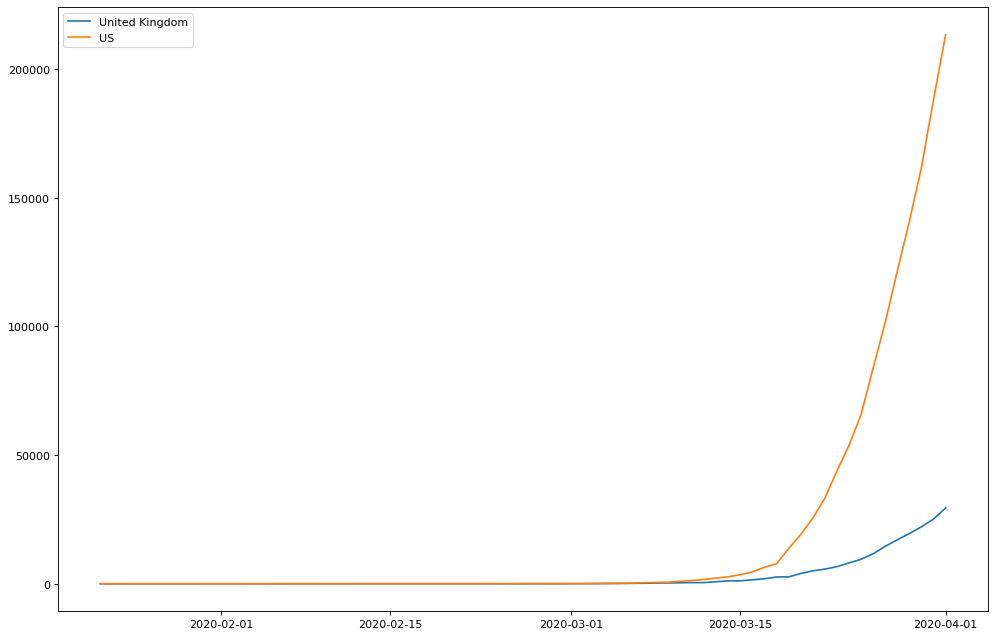

In [194]:
# plot it
fignum = 0
fig = plt.figure(num=fignum, figsize=(15, 10), dpi=80)

# plt.plot(sdf)
# plt.legend(sglv('region'))
print(psdf.columns)
plt.plot(psdf)
plt.legend(list(psdf.columns))
plt.show()

In [199]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scatter(
        x=psdf.index,
        y=psdf.US
    ),
])
fig.show()


In [220]:
%matplotlib qt
fig, axs = plt.subplots(2,1, figsize = (10,6))
axs[0].plot(psdf)
# fig
# ax.plot(psdf.US)
plotly_fig = tls.mpl_to_plotly(fig) ## convert 
iplot(plotly_fig)


/Users/zarek/anaconda/lib/python3.6/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



In [ ]:
px.p

In [166]:
df.iloc[:, glv('region') == "US"] #.columns.to_frame().subregion.unique()

locid,0,1,2,3,4,5,6,7,8,9,...,3245,3246,3247,3248,3249,3250,3251,3252,225
region,US,US,US,US,US,US,US,US,US,US,...,US,US,US,US,US,US,US,US,US
subregion,American Samoa,Guam,Northern Mariana Islands,Puerto Rico,Virgin Islands,Alabama,Alabama,Alabama,Alabama,Alabama,...,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Grand Princess,NaN
combined_key,"American Samoa, US","Guam, US","Northern Mariana Islands, US","Puerto Rico, US","Virgin Islands, US","Autauga, Alabama, US","Baldwin, Alabama, US","Barbour, Alabama, US","Bibb, Alabama, US","Blount, Alabama, US",...,"Unassigned, Utah, US","Unassigned, Vermont, US","Unassigned, Virginia, US","Unassigned, Washington, US","Unassigned, West Virginia, US","Unassigned, Wisconsin, US","Unassigned, Wyoming, US","Grand Princess, US",NaN
lat,-14.271000,13.444300,15.097900,18.220800,18.335800,32.539527,30.727750,31.868263,32.996421,33.982109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.090200
long,-170.132000,144.793700,145.673900,-66.590100,-64.896300,-86.644082,-87.722071,-85.387129,-87.125115,-86.567906,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-95.712900
uid,16.0,316.0,580.0,630.0,850.0,84001001.0,84001003.0,84001005.0,84001007.0,84001009.0,...,84090049.0,84090050.0,84090051.0,84090053.0,84090054.0,84090055.0,84090056.0,84099999.0,NaN
iso2,AS,GU,MP,PR,VI,US,US,US,US,US,...,US,US,US,US,US,US,US,US,NaN
iso3,ASM,GUM,MNP,PRI,VIR,USA,USA,USA,USA,USA,...,USA,USA,USA,USA,USA,USA,USA,USA,NaN
code3,16.0,316.0,580.0,630.0,850.0,840.0,840.0,840.0,840.0,840.0,...,840.0,840.0,840.0,840.0,840.0,840.0,840.0,840.0,NaN
fips,60.0,66.0,69.0,72.0,78.0,1001.0,1003.0,1005.0,1007.0,1009.0,...,90049.0,90050.0,90051.0,90053.0,90054.0,90055.0,90056.0,99999.0,NaN


In [100]:
fignum = 0
fig = plt.figure(num=fignum, figsize=(30, 50), dpi=80)

df = d['all']['df']
glv = df.columns.get_level_values
# df = df.iloc[:, (glv('region') == "US") & (glv('subregion').isna() | (glv('subregion') == "California"))]
df = df.iloc[:, (glv('region') == "US") & (glv('subregion').isna() & (glv('subregion') == "California"))]
glv = df.columns.get_level_values

# print(list(glv('combined_key').unique()))
# print([x for x in (glv('combined_key').isna())])
# print(list(glv('combined_key')[(~glv('combined_key').isna()) & (glv('combined_key').to_series().str.contains("California"))]))
# print(list(glv('combined_key')[(glv('combined_key').isna()) | (glv('combined_key').to_series().str.contains("California"))]))
# plot_regions = plot_data.columns[[0, 1, 2]].get_level_values('region')
# plt.plot(df)
# plt.legend(plot_regions)

df

# plt.plot(df)
# plt.legend(glv('combined_key'))
# plt.show()

2020-01-22
2020-01-23
2020-01-24
2020-01-25
2020-01-26
...
2020-03-28
2020-03-29
2020-03-30
2020-03-31
2020-04-01


<Figure size 2400x4000 with 0 Axes>